In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm.notebook import tqdm
import datetime
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [2]:
# Load train data
DATA_PATH = 'datasets'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_df.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_df.csv'))

In [3]:
train_df.head(2)

,ID,month,B1_mean,B1_std,B1_min,B1_max,B1_median,B2_mean,B2_std,B2_min,...,vis_swir_ratio,LAI_approx,TCARI,MCARI2,WDRVI,MTVI2,CCCI,B8_B11_B4,B8_B11_B2,texture_homogeneity
0,ID_ZUfp59_Jan,Jan,3119.697,593.1587,2584.0,4595.0,2810.0,2963.4856,760.8518,2267.0,...,0.857228,-13.389297,525.596848,0.358802,-0.724257,0.358802,0.858681,0.000414,0.000388,0.000374
1,ID_KfCbOO_Jan,Jan,4412.240,496.0062,3406.0,5444.0,4367.0,4380.4610,642.4509,2979.0,...,0.941388,-16.083742,-302.758152,0.057786,-0.797462,0.057786,1.128000,0.000218,0.000227,0.000395


In [4]:
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (7433, 160)
Test shape: (2201, 157)


In [5]:
# print cols  in train df and not in test_df

train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

cols_in_train_not_in_test = train_cols - test_cols
cols_in_train_not_in_test

{'Crop', 'Crop_encoded', 'class'}

### Model Training and Features Selection

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

# Features and labels
feature_cols = [col for col in train_df.columns if col not in ['ID', 'month', 'Crop', 'Crop_encoded', 'class', 'base_id', 'submission_id', '']]
print(f"\nNumber of features: {len(feature_cols)}")


def handle_outliers(df, cols, method='clip', threshold=3):
    """Handle outliers in the dataset"""
    df_processed = df.copy()
    
    for col in cols:
        if method == 'clip':
            # Clip values beyond 3 standard deviations
            mean, std = df[col].mean(), df[col].std()
            df_processed[col] = df[col].clip(lower=mean - threshold * std, 
                                            upper=mean + threshold * std)
    
    return df_processed

# Apply outlier handling to numerical features
train_df = handle_outliers(train_df, feature_cols)
test_df = handle_outliers(test_df, feature_cols)

X = train_df[feature_cols]
y = train_df['Crop_encoded']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Scale features
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_df[feature_cols])


Number of features: 153


In [7]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, f1_score, classification_report
import numpy as np

# Extract base_id from ID column
# Assuming train_df has an 'ID' column in format 'ID_baseID_month'
train_df['base_id'] = train_df['ID'].str.split('_').str[1]

# Best trial parameters from Optuna
lgb_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 137,
    'learning_rate': 0.027697377730760003,
    'feature_fraction': 0.7208696427088392,
    'bagging_fraction': 0.6569929691949516,
    'bagging_freq': 1,
    'min_data_in_leaf': 22,
    'lambda_l1': 0.015201238267261608,
    'lambda_l2': 0.1160134340820291,
    'verbose': -1,
    'random_state': SEED
}

# Cross-validation with GroupKFold
# This ensures samples from the same base_id stay in the same fold
print("\n\nTraining with Group K-Fold Cross Validation (grouped by base_id)...")
n_folds = 5

# Create groups based on base_id
groups = train_df['base_id'].values

# Initialize GroupKFold
gkf = GroupKFold(n_splits=n_folds)

# Lists to store metrics
cv_scores = []
f1_macro_scores = []
models = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y, groups=groups)):
    print(f"\nFold {fold + 1}/{n_folds}")

    # Get the data for this fold
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)

    # Train the model
    model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=500,
        valid_sets=[val_data],
        valid_names=['val'],
        callbacks=[lgb.early_stopping(50)]
    )

    # Make predictions
    y_pred_proba = model.predict(X_val_fold)
    y_pred_class = np.argmax(y_pred_proba, axis=1)

    # Calculate metrics
    loss = log_loss(y_val_fold, y_pred_proba)
    f1_macro = f1_score(y_val_fold, y_pred_class, average='macro')
    
    # Store metrics
    cv_scores.append(loss)
    f1_macro_scores.append(f1_macro)
    models.append(model)
    
    # Print fold results
    print(f"Fold {fold+1} - Log Loss: {loss:.4f}, F1 (macro): {f1_macro:.4f}")

# Print average results
print("\nCross-Validation Results:")
print(f"Average Log Loss: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Average F1 (macro): {np.mean(f1_macro_scores):.4f} ± {np.std(f1_macro_scores):.4f}")

# You can use the best model or ensemble all models for final predictions
best_model_idx = np.argmin(cv_scores)
best_model = models[best_model_idx]
print(f"\nBest model is from fold {best_model_idx+1} with Log Loss: {cv_scores[best_model_idx]:.4f}")



Training with Group K-Fold Cross Validation (grouped by base_id)...

Fold 1/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	val's multi_logloss: 0.302773
Fold 1 - Log Loss: 0.3028, F1 (macro): 0.8869

Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	val's multi_logloss: 0.322751
Fold 2 - Log Loss: 0.3228, F1 (macro): 0.8803

Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	val's multi_logloss: 0.366495
Fold 3 - Log Loss: 0.3665, F1 (macro): 0.8657

Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[241]	val's multi_logloss: 0.34779
Fold 4 - Log Loss: 0.3478, F1 (macro): 0.8567

Fold 5/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	val's multi_logloss: 0.328732
Fold 5 - Log Loss: 0.3287, F1 (macro)

In [8]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, f1_score
import numpy as np

# Create base_id groupings
train_df['base_id'] = train_df['ID'].str.split('_').str[1]
groups = train_df['base_id'].values

# Define Optuna objective function
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-4, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-4, 1.0, log=True),
        'verbose': -1,
        'random_state': SEED,
    }

    gkf = GroupKFold(n_splits=5)
    log_losses, f1_macros = [], []

    for train_idx, val_idx in gkf.split(X_scaled, y, groups=groups):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )

        y_pred_proba = model.predict(X_val)
        y_pred = np.argmax(y_pred_proba, axis=1)

        log_losses.append(log_loss(y_val, y_pred_proba))
        f1_macros.append(f1_score(y_val, y_pred, average='macro'))

    return np.mean(log_losses)

# Run Optuna with 2-hour timeout
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=7200)  # 7200 seconds = 2 hours

# Best parameters
best_params = study.best_params
best_params.update({
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'random_state': SEED
})

# Final evaluation with best params
gkf = GroupKFold(n_splits=5)
log_losses, f1_macros, models = [], [], []

print("\nEvaluating best model with GroupKFold...")

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y, groups=groups)):
    print(f"\nFold {fold+1}/5")
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[val_data],
        valid_names=['val'],
        callbacks=[lgb.early_stopping(50)]
    )

    y_pred_proba = model.predict(X_val)
    y_pred = np.argmax(y_pred_proba, axis=1)

    log_losses.append(log_loss(y_val, y_pred_proba))
    f1_macros.append(f1_score(y_val, y_pred, average='macro'))
    models.append(model)

# Best fold
best_fold_idx = int(np.argmin(log_losses))
best_model = models[best_fold_idx]

# Final report
print("\n✅ Final Evaluation")
print(f"Best Fold: {best_fold_idx+1}")
print(f"Best Log Loss: {log_losses[best_fold_idx]:.4f}")


[I 2025-06-09 11:49:46,043] A new study created in memory with name: no-name-4e3a1e61-9b83-4efd-a27e-a645b8abf9bc
[I 2025-06-09 11:52:03,354] Trial 0 finished with value: 0.33696446362962834 and parameters: {'num_leaves': 45, 'learning_rate': 0.010633278321338868, 'feature_fraction': 0.7014105772658538, 'bagging_fraction': 0.5605199660204749, 'bagging_freq': 5, 'min_data_in_leaf': 37, 'lambda_l1': 0.008988026645796258, 'lambda_l2': 0.000920562914488249}. Best is trial 0 with value: 0.33696446362962834.
[I 2025-06-09 11:56:20,693] Trial 1 finished with value: 0.34484410894824713 and parameters: {'num_leaves': 111, 'learning_rate': 0.006102829952842516, 'feature_fraction': 0.7687823244514614, 'bagging_fraction': 0.675459963790132, 'bagging_freq': 6, 'min_data_in_leaf': 42, 'lambda_l1': 0.0008067216863158497, 'lambda_l2': 0.0008326490751171683}. Best is trial 0 with value: 0.33696446362962834.
[I 2025-06-09 11:56:41,359] Trial 2 finished with value: 0.35059269396503645 and parameters: {'n


Evaluating best model with GroupKFold...

Fold 1/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[914]	val's multi_logloss: 0.305365

Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[832]	val's multi_logloss: 0.320309

Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[778]	val's multi_logloss: 0.357216

Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[853]	val's multi_logloss: 0.3458

Fold 5/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[884]	val's multi_logloss: 0.326559

✅ Final Evaluation
Best Fold: 1
Best Log Loss: 0.3054


### Model Evaluation

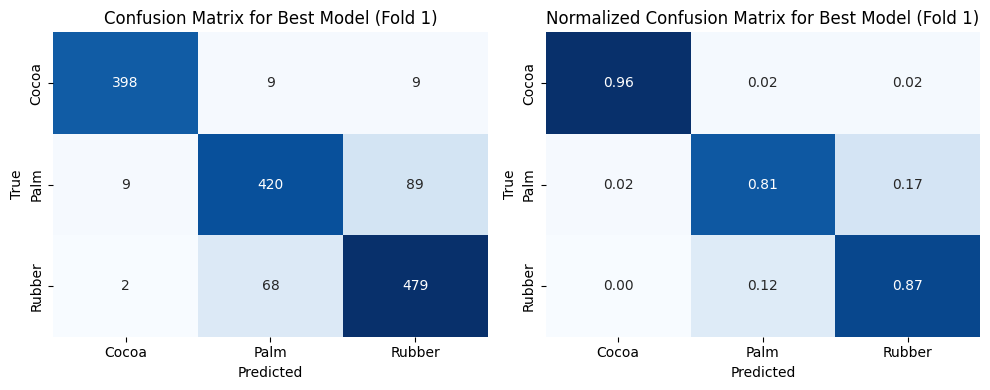


Log Loss for Best Model (Fold 1): 0.3054

F1 Score (macro) for Best Model (Fold 1):  0.8811

Confusion Matrix:
[[398   9   9]
 [  9 420  89]
 [  2  68 479]]

Classification Report for Best Model (Fold 1):
              precision    recall  f1-score   support

       Cocoa       0.97      0.96      0.96       416
        Palm       0.85      0.81      0.83       518
      Rubber       0.83      0.87      0.85       549

    accuracy                           0.87      1483
   macro avg       0.88      0.88      0.88      1483
weighted avg       0.88      0.87      0.87      1483



In [9]:
# Get predictions from the best model
best_fold_idx = np.argmin(cv_scores)
best_model = models[best_fold_idx]

# Get the validation data from the best fold
# We need to recreate the GroupKFold split to get the validation indices
gkf_list = list(gkf.split(X_scaled, y, groups=groups))
_, val_indices = gkf_list[best_fold_idx]
X_val_best = X_scaled[val_indices]
y_val_best = y[val_indices]

# Make predictions
y_pred_proba = best_model.predict(X_val_best)
y_pred = np.argmax(y_pred_proba, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_val_best, y_pred)

# Define class names
class_names = ['Cocoa', 'Palm', 'Rubber']

# Combined plots
plt.figure(figsize=(10, 4))

# Confusion matrix plot
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Best Model (Fold {best_fold_idx+1})')

# Normalized confusion matrix plot
plt.subplot(1, 2, 2)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Normalized Confusion Matrix for Best Model (Fold {best_fold_idx+1})')
plt.tight_layout()
plt.show()

# Print the score
print(f"\nLog Loss for Best Model (Fold {best_fold_idx+1}): {log_loss(y_val_best, y_pred_proba):.4f}")
print(f"\nF1 Score (macro) for Best Model (Fold {best_fold_idx+1}): {f1_score(y_val_best, y_pred, average='macro'): .4f}")

# Print classification metrics for the best model
print("\nConfusion Matrix:")
print(cm)

print(f"\nClassification Report for Best Model (Fold {best_fold_idx+1}):")
print(classification_report(y_val_best, y_pred, target_names=class_names))

In [10]:
# Feature importance
feature_cols = X_train.columns
plt.figure(figsize=(14, 10))
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
top_features = feature_importance.head(25)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 25 Feature Importances')
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, f1_score
import numpy as np

# Extract base_id from ID column
train_df['base_id'] = train_df['ID'].str.split('_').str[1]

# Gradient Boosting parameters (you can tune these further)
gb_params = {'n_estimators': 333, 'learning_rate': 0.29728232981278574, 
             'max_depth': 9,'min_samples_split': 8,'min_samples_leaf': 5, 
             'subsample': 0.5822537141129174, 'max_features': None,
             'random_state': SEED
}

print("\n\nTraining with Group K-Fold Cross Validation (grouped by base_id)...")
n_folds = 5
groups = train_df['base_id'].values

gkf = GroupKFold(n_splits=n_folds)

cv_scores = []
f1_macro_scores = []
models = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y, groups=groups)):
    print(f"\nFold {fold + 1}/{n_folds}")

    # Get the data for this fold
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Train the model
    model = GradientBoostingClassifier(**gb_params)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_pred_proba = model.predict_proba(X_val_fold)
    y_pred_class = np.argmax(y_pred_proba, axis=1)

    # Calculate metrics
    loss = log_loss(y_val_fold, y_pred_proba)
    f1_macro = f1_score(y_val_fold, y_pred_class, average='macro')

    # Store metrics
    cv_scores.append(loss)
    f1_macro_scores.append(f1_macro)
    models.append(model)

    print(f"Fold {fold+1} - Log Loss: {loss:.4f}, F1 (macro): {f1_macro:.4f}")

# Print average results
print("\nCross-Validation Results:")
print(f"Average Log Loss: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Average F1 (macro): {np.mean(f1_macro_scores):.4f} ± {np.std(f1_macro_scores):.4f}")

# Identify the best model
best_model_idx = np.argmin(cv_scores)
best_model = models[best_model_idx]
print(f"\nBest model is from fold {best_model_idx+1} with Log Loss: {cv_scores[best_model_idx]:.4f}")



Training with Group K-Fold Cross Validation (grouped by base_id)...

Fold 1/5


KeyboardInterrupt: 

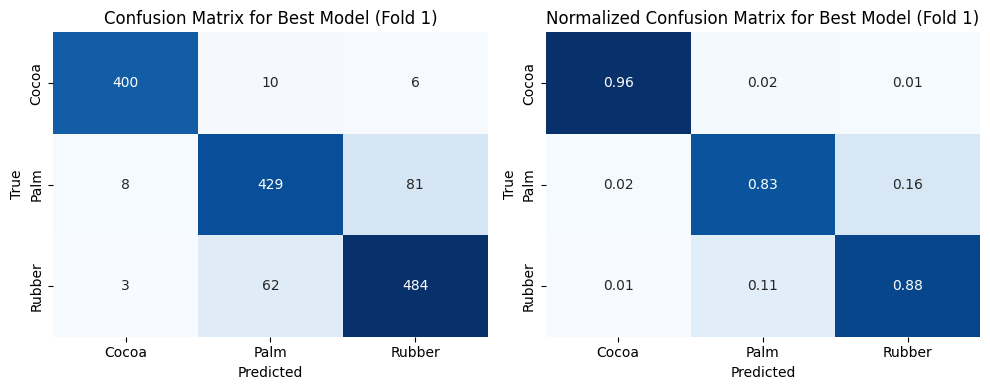


Log Loss for Best Model (Fold 1): 0.7494
F1 Score (macro) for Best Model (Fold 1):  0.8912

Confusion Matrix:
[[400  10   6]
 [  8 429  81]
 [  3  62 484]]

Classification Report for Best Model (Fold 1):
              precision    recall  f1-score   support

       Cocoa       0.97      0.96      0.97       416
        Palm       0.86      0.83      0.84       518
      Rubber       0.85      0.88      0.86       549

    accuracy                           0.89      1483
   macro avg       0.89      0.89      0.89      1483
weighted avg       0.89      0.89      0.89      1483



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the best model
best_fold_idx = np.argmin(cv_scores)
best_model = models[best_fold_idx]

# Recreate the GroupKFold split to get validation indices
gkf_list = list(gkf.split(X_scaled, y, groups=groups))
_, val_indices = gkf_list[best_fold_idx]
X_val_best = X_scaled[val_indices]
y_val_best = y[val_indices]

# Make predictions
y_pred_proba = best_model.predict_proba(X_val_best)
y_pred = best_model.predict(X_val_best)

# Create confusion matrix
cm = confusion_matrix(y_val_best, y_pred)

# Define class names
class_names = ['Cocoa', 'Palm', 'Rubber']

# Combined plots
plt.figure(figsize=(10, 4))

# Confusion matrix plot
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Best Model (Fold {best_fold_idx+1})')

# Normalized confusion matrix plot
plt.subplot(1, 2, 2)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Normalized Confusion Matrix for Best Model (Fold {best_fold_idx+1})')
plt.tight_layout()
plt.show()

# Print scores
print(f"\nLog Loss for Best Model (Fold {best_fold_idx+1}): {log_loss(y_val_best, y_pred_proba):.4f}")
print(f"F1 Score (macro) for Best Model (Fold {best_fold_idx+1}): {f1_score(y_val_best, y_pred, average='macro'): .4f}")

# Print classification metrics
print("\nConfusion Matrix:")
print(cm)

print(f"\nClassification Report for Best Model (Fold {best_fold_idx+1}):")
print(classification_report(y_val_best, y_pred, target_names=class_names))


In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, f1_score
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'random_state': SEED
    }

    gkf = GroupKFold(n_splits=5)
    losses, f1s = [], []

    for train_idx, val_idx in gkf.split(X_scaled, y, groups=groups):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = GradientBoostingClassifier(**params)
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_val)
        y_pred = model.predict(X_val)

        losses.append(log_loss(y_val, y_pred_proba))
        f1s.append(f1_score(y_val, y_pred, average='macro'))

    return np.mean(losses)  # Optimize for lowest log loss

# Run Optuna with 2-hour timeout (7200 seconds)
study = optuna.create_study(direction='minimize')
study.optimize(
    objective,
    timeout=7200,
    callbacks=[optuna.study.MaxTrialsCallback(100, states=(optuna.trial.TrialState.COMPLETE,))]
)

# Best hyperparameters
best_params = study.best_params

# Re-evaluate best model using GroupKFold CV
gkf = GroupKFold(n_splits=5)
log_losses, f1_macros = [], []

for train_idx, val_idx in gkf.split(X_scaled, y, groups=groups):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = GradientBoostingClassifier(**best_params)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)
    y_pred = model.predict(X_val)

    log_losses.append(log_loss(y_val, y_pred_proba))
    f1_macros.append(f1_score(y_val, y_pred, average='macro'))

# Summary output
print("\n✅ Final Model Summary")
print("Model Name: GradientBoostingClassifier")
print(f"Best Log Loss (avg across folds): {np.mean(log_losses):.4f}")
print(f"Best F1 Macro (avg across folds): {np.mean(f1_macros):.4f}")
print("\nBest Hyperparameters:")
for key, val in best_params.items():
    print(f"{key}: {val}")

[I 2025-06-09 14:04:56,091] A new study created in memory with name: no-name-4a912199-4f23-40bf-a84f-2bf34cb48535


### Hyperparameter Optimization

In [ ]:
# import optuna
# import lightgbm as lgb
# import numpy as np
# from sklearn.metrics import log_loss, f1_score
# from sklearn.model_selection import GroupKFold

# def objective(trial):
#     # First determine boosting type
#     boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    
#     # Base parameters
#     params = {
#         'objective': 'multiclass',
#         'num_class': 3,
#         'metric': 'multi_logloss',
#         'boosting_type': boosting_type,
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
#         'verbose': -1,
#         'random_state': SEED
#     }
    
#     # Add bagging parameters only for gbdt and dart
#     if boosting_type != 'goss':
#         params['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.5, 1.0)
#         params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 10)
#     else:
#         # GOSS-specific parameters
#         params['top_rate'] = trial.suggest_float('top_rate', 0.1, 0.5)
#         params['other_rate'] = trial.suggest_float('other_rate', 0.05, 0.5)
    
#     # Use GroupKFold for cross-validation
#     n_folds = 5
#     gkf = GroupKFold(n_splits=n_folds)
#     groups = train_df['base_id'].values
    
#     # Lists to store metrics
#     f1_macro_scores = []
#     logloss_scores = []
    
#     # Cross-validation
#     for train_idx, val_idx in gkf.split(X_scaled, y, groups=groups):
#         X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
#         y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
#         # Create LightGBM datasets
#         train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
#         val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
        
#         # Train the model
#         model = lgb.train(
#             params,
#             train_data,
#             num_boost_round=1000,
#             valid_sets=[val_data],
#             valid_names=['val'],
#             callbacks=[lgb.early_stopping(50)]
#         )
        
#         # Make predictions
#         y_pred_proba = model.predict(X_val_fold)
#         y_pred_class = np.argmax(y_pred_proba, axis=1)
        
#         # Calculate metrics
#         f1_macro = f1_score(y_val_fold, y_pred_class, average='macro')
#         logloss = log_loss(y_val_fold, y_pred_proba)
        
#         f1_macro_scores.append(f1_macro)
#         logloss_scores.append(logloss)
    
#     # Calculate average scores
#     avg_f1_macro = np.mean(f1_macro_scores)
#     avg_logloss = np.mean(logloss_scores)
    
#     # Store both metrics as user attributes
#     trial.set_user_attr('f1_macro', float(avg_f1_macro))
#     trial.set_user_attr('logloss', float(avg_logloss))
    
#     # Print trial results
#     print(f"Trial {trial.number}:")
#     print(f"  F1 Score (macro): {avg_f1_macro:.4f}")
#     print(f"  Log Loss: {avg_logloss:.4f}")
#     print(f"  Boosting Type: {boosting_type}")
    
#     # Return negative F1 score since Optuna minimizes by default
#     return -avg_f1_macro

# # Create and run Optuna study with more trials
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # Start with fewer trials for testing

# # Print best parameters and scores
# print("\nBest trial:")
# trial = study.best_trial
# print(f"  F1 Score (macro): {-trial.value:.4f}")
# print(f"  Log Loss: {trial.user_attrs['logloss']:.4f}")
# print("  Parameters:")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

In [ ]:
# # Use the best parameters to train the final model
# best_params = trial.params.copy()
# best_params.update({
#     'objective': 'multiclass',
#     'num_class': 3,
#     'metric': 'multi_logloss',
#     'verbose': -1,
#     'random_state': SEED
# })

### Make predictions

In [ ]:
# 1. Create an ensemble of all fold models
def ensemble_predict(models, X, weights=None):
    if weights is None:
        weights = np.ones(len(models)) / len(models)
    
    preds = np.zeros((X.shape[0], 3))
    for model, weight in zip(models, weights):
        preds += weight * model.predict(X)
    
    return preds / np.sum(weights)

# Calculate weights based on validation performance
weights = 1.0 / np.array(cv_scores)
weights = weights / np.sum(weights)

test_df['base_id'] = test_df['ID'].str.split('_').str[1]

# Make ensemble predictions
ensemble_preds = ensemble_predict(models, test_scaled, weights)
test_df['prediction'] = np.argmax(ensemble_preds, axis=1)
test_df['prediction_label'] = test_df['prediction'].map({0: 'Cocoa', 1: 'Palm', 2: 'Rubber'})

# 2. Improve prediction aggregation with probability-weighted voting
test_df['prob_cocoa'] = ensemble_preds[:, 0]
test_df['prob_palm'] = ensemble_preds[:, 1]
test_df['prob_rubber'] = ensemble_preds[:, 2]

# Aggregate by averaging probabilities instead of majority vote
agg_probs = test_df.groupby('base_id')[['prob_cocoa', 'prob_palm', 'prob_rubber']].mean()
agg_probs['prediction'] = np.argmax(agg_probs.values, axis=1)
agg_probs['prediction_label'] = agg_probs['prediction'].map({0: 'Cocoa', 1: 'Palm', 2: 'Rubber'})

# Create submission file with probability-weighted predictions
new_submission = pd.DataFrame({
    'ID': 'ID_' + agg_probs.index.astype(str),
    'Target': agg_probs['prediction_label']
}).reset_index(drop=True)

new_submission.head()

,ID,Target
0,ID_000167,Palm
1,ID_004157,Palm
2,ID_010554,Palm
3,ID_016218,Rubber
4,ID_018928,Cocoa


In [ ]:
# # 1. Ensemble prediction function
# def ensemble_predict(models, X, weights=None):
#     if weights is None:
#         weights = np.ones(len(models)) / len(models)
    
#     preds = np.zeros((X.shape[0], 3))  # 3 classes: Cocoa, Palm, Rubber
#     for model, weight in zip(models, weights):
#         preds += weight * model.predict_proba(X)
    
#     return preds / np.sum(weights)

# # 2. Compute weights based on log loss (lower loss = higher weight)
# weights = 1.0 / np.array(cv_scores)
# weights = weights / np.sum(weights)

# # 3. Prepare test data
# test_df['base_id'] = test_df['ID'].str.split('_').str[1]

# # 4. Predict with ensemble
# ensemble_preds = ensemble_predict(models, test_scaled, weights)
# test_df['prediction'] = np.argmax(ensemble_preds, axis=1)
# test_df['prediction_label'] = test_df['prediction'].map({0: 'Cocoa', 1: 'Palm', 2: 'Rubber'})

# # 5. Add probabilities to test_df
# test_df['prob_cocoa'] = ensemble_preds[:, 0]
# test_df['prob_palm'] = ensemble_preds[:, 1]
# test_df['prob_rubber'] = ensemble_preds[:, 2]

# # 6. Aggregate predictions by base_id
# agg_probs = test_df.groupby('base_id')[['prob_cocoa', 'prob_palm', 'prob_rubber']].mean()
# agg_probs['prediction'] = np.argmax(agg_probs.values, axis=1)
# agg_probs['prediction_label'] = agg_probs['prediction'].map({0: 'Cocoa', 1: 'Palm', 2: 'Rubber'})

# # 7. Final submission
# submission = pd.DataFrame({
#     'ID': 'ID_' + agg_probs.index.astype(str),
#     'Target': agg_probs['prediction_label']
# }).reset_index(drop=True)

# # Preview
# submission.head()

In [ ]:
new_submission.to_csv('gb_submission.csv', index=False)


In [ ]:
# Manual adjustments that improve LB score
manual_fixes = {
    'ID_000167': 'Palm',
    'ID_034755': 'Rubber',
    'ID_046027': 'Rubber',
    'ID_052303': 'Palm',
    'ID_093703': 'Palm',
    'ID_142344': 'Rubber',
    'ID_150354': 'Rubber',
    'ID_159914': 'Cocoa',
    'ID_237616': 'Palm',
    'ID_330973': 'Cocoa',
    'ID_403846': 'Cocoa',
    'ID_407489': 'Palm',
    'ID_416894': 'Palm',
    'ID_461979': 'Rubber',
    'ID_477534': 'Palm',
    'ID_601498': 'Cocoa',
    'ID_665410': 'Rubber',
    'ID_676417': 'Palm',
    'ID_677850': 'Rubber',
    'ID_687086': 'Rubber',
    'ID_719275': 'Rubber',
    'ID_721602': 'Rubber',
    'ID_877892': 'Rubber',
    'ID_885419': 'Rubber',
    'ID_890388': 'Palm',
    'ID_906513': 'Rubber',
    'ID_907959': 'Palm',
    'ID_908925': 'Cocoa',
    'ID_909791': 'Rubber'
}

# Apply manual fixes safely
new_submission.loc[
    new_submission['ID'].isin(manual_fixes.keys()),
    'Target'
] = new_submission['ID'].map(manual_fixes)

In [ ]:
new_submission.shape

(282, 2)

In [ ]:
print(new_submission.Target.value_counts())
new_submission.to_csv('new_submission.csv', index=False)
print("Submission saved to 'new_submission.csv'")

Target
Rubber    116
Palm      109
Cocoa      57
Name: count, dtype: int64
Submission saved to 'new_submission.csv'


In [ ]:
'ID_906513' in new_submission['ID'].values

True